In [97]:
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import matplotlib.pyplot as plt
from bokeh.io import output_file
from bokeh.models import GeoJSONDataSource, HoverTool, Range1d, ColumnDataSource, Div
from bokeh.transform import cumsum, dodge
from bokeh.palettes import YlGnBu9
from bokeh.plotting import figure, show
from bokeh.layouts import row, column

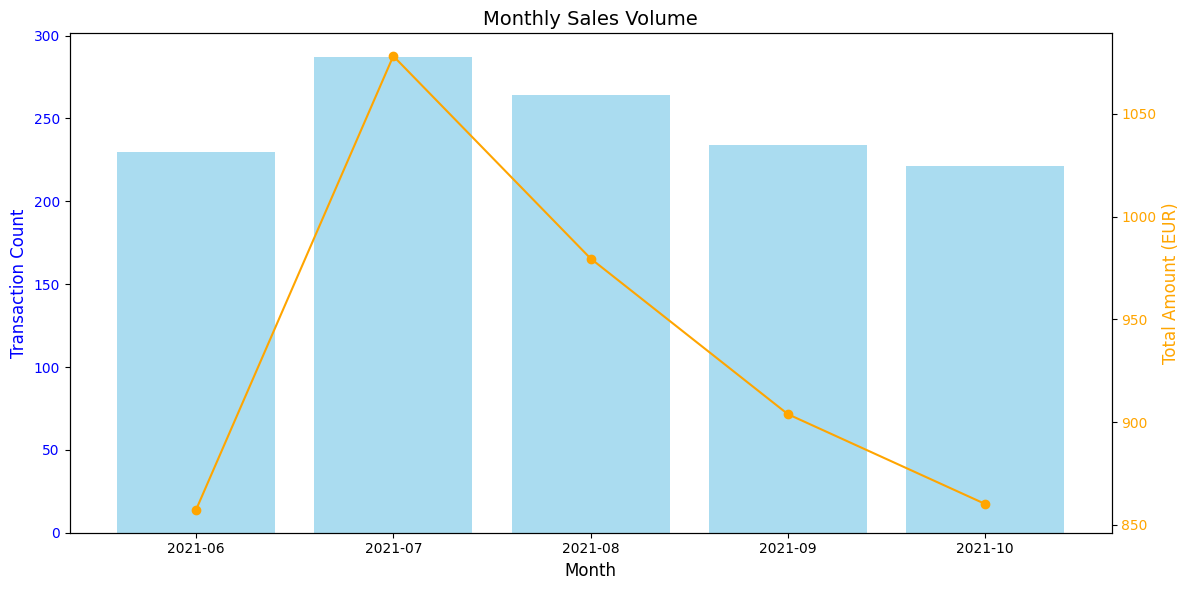

In [111]:
### 1. Sales volume
file_paths = glob.glob(os.path.join('Data', 'sales_*.csv'))
sales_dfs = [pd.read_csv(file) for file in file_paths]
sales_df = pd.concat(sales_dfs, ignore_index=True)
sales_df = sales_df[(sales_df['Transaction Type'] == 'Charge') &
                    (sales_df['Product id'] == 'com.vansteinengroentjes.apps.ddfive')]

sales_df['Transaction Date'] = pd.to_datetime(sales_df['Transaction Date'])


sales_df['Month'] = sales_df['Transaction Date'].dt.to_period('M')


monthly_sales = sales_df.groupby('Month').agg(
    transaction_count=('Transaction Date', 'count'),
    total_amount=('Amount (Merchant Currency)', 'sum')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.bar(monthly_sales['Month'].astype(str), monthly_sales['transaction_count'], color='skyblue', label='Transaction Count', alpha=0.7)
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Transaction Count', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.plot(monthly_sales['Month'].astype(str), monthly_sales['total_amount'], color='orange', marker='o', label='Total Amount (EUR)')
ax2.set_ylabel('Total Amount (EUR)', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')


plt.title('Monthly Sales Volume', fontsize=14)
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()


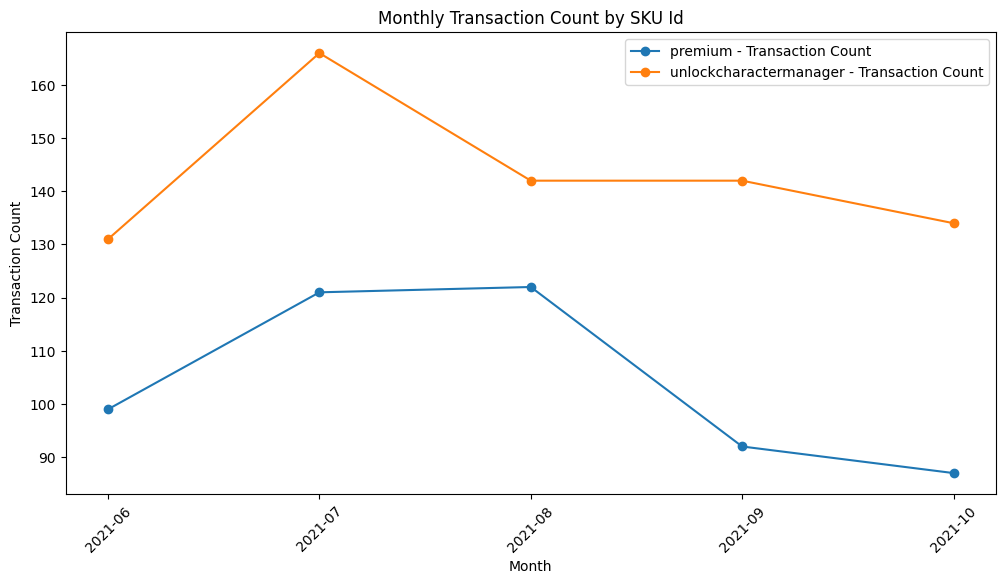

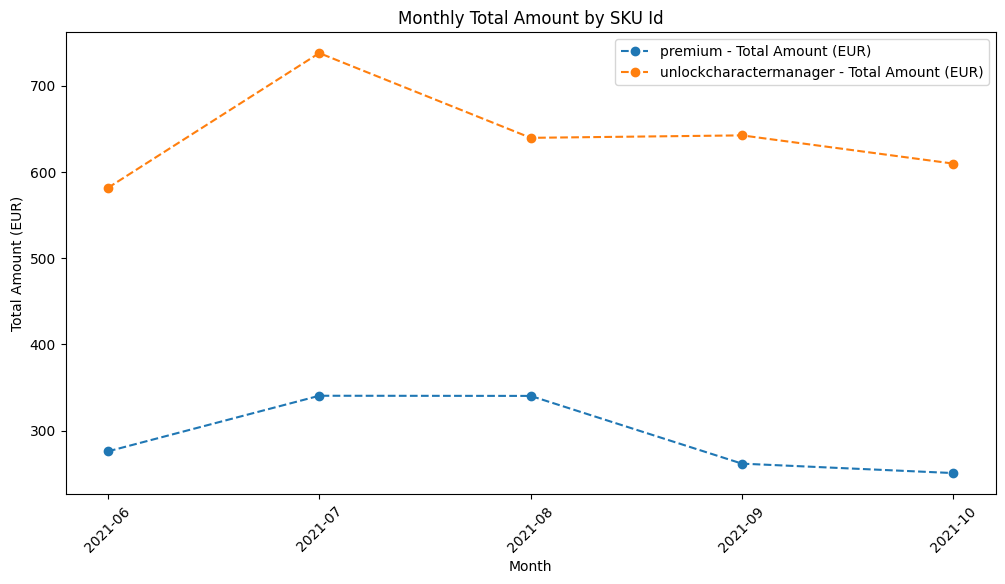

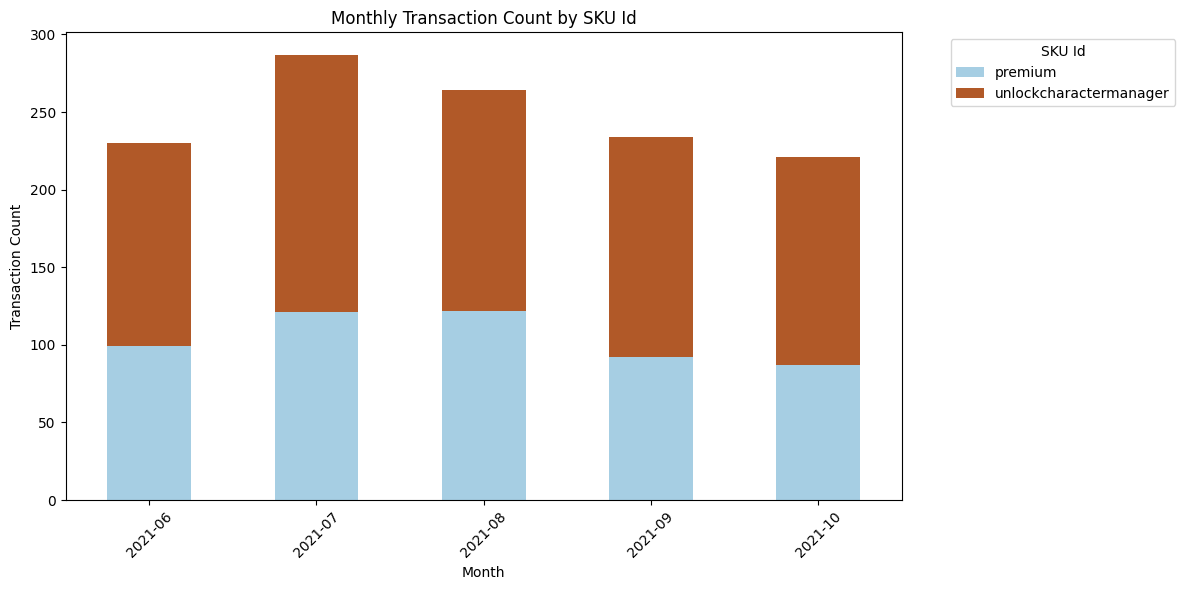

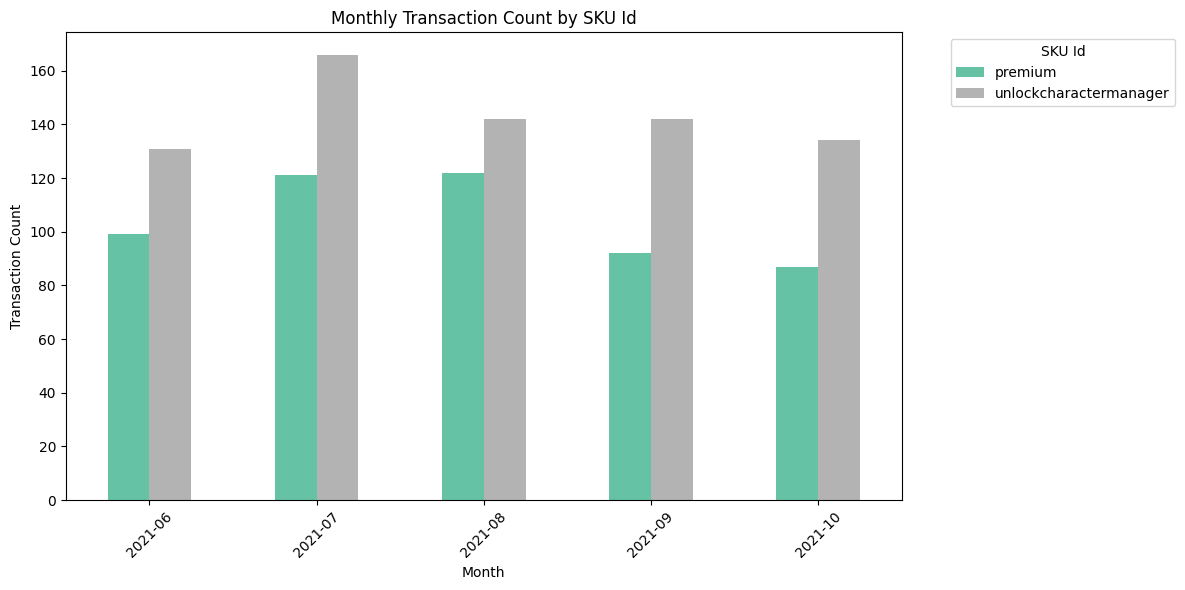

In [112]:
### 2. Attribute Segmentation and Filtering
sales_df['Transaction Date'] = pd.to_datetime(sales_df['Transaction Date'])
sales_df['Month'] = sales_df['Transaction Date'].dt.to_period('M')

sku_sales = sales_df.groupby(['Sku Id', 'Month']).agg(
    transaction_count=('Transaction Date', 'count'),
    total_amount=('Amount (Merchant Currency)', 'sum')
).reset_index()

sku_ids = sku_sales['Sku Id'].unique()

plt.figure(figsize=(12, 6))
for sku in sku_ids:
    sku_data = sku_sales[sku_sales['Sku Id'] == sku]
    plt.plot(sku_data['Month'].astype(str), sku_data['transaction_count'], marker='o', label=f'{sku} - Transaction Count')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.title('Monthly Transaction Count by SKU Id')
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
for sku in sku_ids:
    sku_data = sku_sales[sku_sales['Sku Id'] == sku]
    plt.plot(sku_data['Month'].astype(str), sku_data['total_amount'], marker='o', linestyle='--', label=f'{sku} - Total Amount (EUR)')
plt.xlabel('Month')
plt.ylabel('Total Amount (EUR)')
plt.title('Monthly Total Amount by SKU Id')
plt.legend()
plt.xticks(rotation=45)
plt.show()

sku_transaction_counts = sales_df.groupby(['Month', 'Sku Id'])['Transaction Date'].count().unstack()

#plot stacked bar chart
sku_transaction_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Paired')
plt.title('Monthly Transaction Count by SKU Id')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.legend(title='SKU Id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

sku_transaction_counts.plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title('Monthly Transaction Count by SKU Id')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.legend(title='SKU Id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [113]:
### crashes
file_paths = glob.glob(os.path.join('Data', 'stats_crashes_*.csv'))
stats_crashes_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_crashes_dfs = pd.concat(stats_crashes_dfs, ignore_index=True)
print("Combined DataFrame head:")
stats_crashes_dfs

Combined DataFrame head:


,Date,Package Name,Daily Crashes,Daily ANRs
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,15,1
1,2021-06-02,com.vansteinengroentjes.apps.ddfive,12,1
2,2021-06-03,com.vansteinengroentjes.apps.ddfive,20,1
3,2021-06-04,com.vansteinengroentjes.apps.ddfive,13,0
4,2021-06-05,com.vansteinengroentjes.apps.ddfive,14,0
...,...,...,...,...
209,2021-12-27,com.vansteinengroentjes.apps.ddfive,64,0
210,2021-12-28,com.vansteinengroentjes.apps.ddfive,60,0
211,2021-12-29,com.vansteinengroentjes.apps.ddfive,37,0
212,2021-12-30,com.vansteinengroentjes.apps.ddfive,46,1


In [101]:
### stats_ratings_country
file_paths = glob.glob(os.path.join('Data', 'stats_ratings_*_country.csv'))
stats_ratings_country_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_ratings_country_dfs = pd.concat(stats_ratings_country_dfs, ignore_index=True)
print("Combined DataFrame head:")
stats_ratings_country_dfs

Combined DataFrame head:


,Date,Package Name,Country,Daily Average Rating,Total Average Rating
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,AR,NaN,4.20
1,2021-06-01,com.vansteinengroentjes.apps.ddfive,AT,NaN,3.91
2,2021-06-01,com.vansteinengroentjes.apps.ddfive,AU,NaN,4.19
3,2021-06-01,com.vansteinengroentjes.apps.ddfive,BA,NaN,5.00
4,2021-06-01,com.vansteinengroentjes.apps.ddfive,BD,NaN,5.00
...,...,...,...,...,...
18612,2021-12-31,com.vansteinengroentjes.apps.ddfive,US,NaN,4.04
18613,2021-12-31,com.vansteinengroentjes.apps.ddfive,UY,NaN,4.86
18614,2021-12-31,com.vansteinengroentjes.apps.ddfive,VE,NaN,4.00
18615,2021-12-31,com.vansteinengroentjes.apps.ddfive,VN,NaN,5.00


In [102]:
### stats_rating_overview
file_paths = glob.glob(os.path.join('Data', 'stats_ratings_*_overview.csv'))
stats_ratings_overview_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
stats_ratings_overview_dfs = pd.concat(stats_ratings_overview_dfs, ignore_index=True)
print("Combined DataFrame head:")
stats_ratings_overview_dfs

Combined DataFrame head:


,Date,Package Name,Daily Average Rating,Total Average Rating
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,5.0,4.15
1,2021-06-02,com.vansteinengroentjes.apps.ddfive,2.0,4.15
2,2021-06-03,com.vansteinengroentjes.apps.ddfive,NaN,4.15
3,2021-06-04,com.vansteinengroentjes.apps.ddfive,NaN,4.15
4,2021-06-05,com.vansteinengroentjes.apps.ddfive,NaN,4.15
...,...,...,...,...
209,2021-12-27,com.vansteinengroentjes.apps.ddfive,NaN,4.14
210,2021-12-28,com.vansteinengroentjes.apps.ddfive,4.0,4.14
211,2021-12-29,com.vansteinengroentjes.apps.ddfive,NaN,4.14
212,2021-12-30,com.vansteinengroentjes.apps.ddfive,NaN,4.14


In [103]:
### reviews 
file_paths = glob.glob(os.path.join('Data', 'reviews_*.csv'))
reviews_dfs = [pd.read_csv(file, encoding='utf-16') for file in file_paths]
reviews_dfs = pd.concat(reviews_dfs, ignore_index=True)
reviews_dfs['Developer Reply Date and Time'] = pd.to_datetime(reviews_dfs['Developer Reply Date and Time'])
reviews_dfs['Review Submit Date and Time'] = pd.to_datetime(reviews_dfs['Review Submit Date and Time'])
print("Combined DataFrame head:")
reviews_dfs

Combined DataFrame head:


,Package Name,App Version Code,App Version Name,Reviewer Language,Device,Review Submit Date and Time,Review Submit Millis Since Epoch,Review Last Update Date and Time,Review Last Update Millis Since Epoch,Star Rating,Review Title,Review Text,Developer Reply Date and Time,Developer Reply Millis Since Epoch,Developer Reply Text,Review Link
0,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,flox,2021-06-01 10:28:24+00:00,1622543304307,2021-06-01T10:28:24Z,1622543304307,5,NaN,NaN,NaT,NaN,NaN,NaN
1,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,river,2021-06-02 16:16:24+00:00,1622650584378,2021-06-02T16:16:24Z,1622650584378,2,NaN,"No monster descriptions, just stats. If there ...",2021-06-02 16:40:58+00:00,1.622652e+12,Unlocking either the dm tools or the character...,http://play.google.com/console/developers/6648...
2,com.vansteinengroentjes.apps.ddfive,NaN,NaN,en,U693CL,2021-06-08 06:01:48+00:00,1623132108319,2021-06-08T06:01:48Z,1623132108319,5,NaN,Wizard,NaT,NaN,NaN,http://play.google.com/console/developers/6648...
3,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,taimen,2020-04-20 19:31:03+00:00,1587411063002,2021-06-08T22:44:27Z,1623192267754,5,NaN,It helps you find what you need for DND 5e,NaT,NaN,NaN,http://play.google.com/console/developers/6648...
4,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,de,OnePlus7TPro,2021-06-12 11:20:20+00:00,1623496820823,2021-06-12T11:21:34Z,1623496894692,3,NaN,Would be very useful if it wasn't so buggy. Cu...,NaT,NaN,NaN,http://play.google.com/console/developers/6648...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,com.vansteinengroentjes.apps.ddfive,NaN,NaN,fr,klein,2021-12-11 07:13:14+00:00,1639206794948,2021-12-11T07:13:14Z,1639206794948,1,NaN,NaN,NaT,NaN,NaN,NaN
74,com.vansteinengroentjes.apps.ddfive,NaN,NaN,en,troika_sprout,2021-12-13 18:54:40+00:00,1639421680663,2021-12-13T18:54:40Z,1639421680663,5,NaN,NaN,NaT,NaN,NaN,NaN
75,com.vansteinengroentjes.apps.ddfive,288.0,8.1.1,en,beyond1q,2021-12-13 22:56:04+00:00,1639436164880,2021-12-13T22:56:04Z,1639436164880,4,NaN,NaN,NaT,NaN,NaN,NaN
76,com.vansteinengroentjes.apps.ddfive,289.0,8.1.2,en,berlna,2021-12-28 14:19:58+00:00,1640701198042,2021-12-28T14:19:58Z,1640701198042,4,NaN,This app is amazing! There is a lot of content...,NaT,NaN,NaN,http://play.google.com/console/developers/6648...


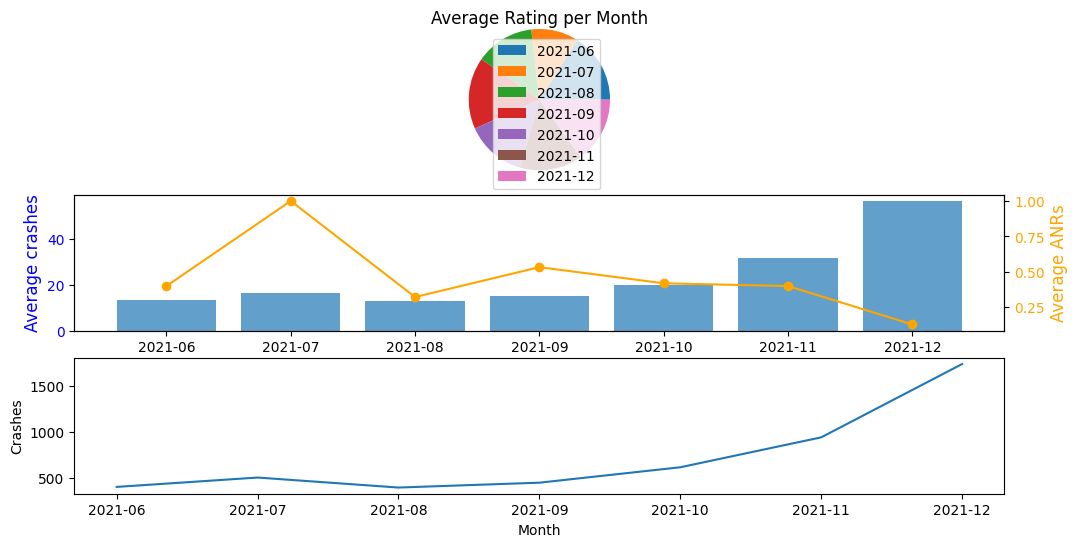

In [104]:
### 3. Ratings vs Stability
### user satisfaction
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(12, 6))

stats_ratings_country_dfs['Date'] = pd.to_datetime(stats_ratings_country_dfs['Date'])
stats_ratings_country_dfs['Month'] = stats_ratings_country_dfs['Date'].dt.to_period('M')

group_ratings_by_month = stats_ratings_country_dfs.groupby(['Month']).agg(
    daily_avg_per_country = ('Daily Average Rating', 'mean'),
).reset_index()
group_ratings_by_month['Daily Average Rating per Month'] = group_ratings_by_month['daily_avg_per_country']
stats_crashes_dfs['Date'] = pd.to_datetime(stats_crashes_dfs['Date'])
stats_crashes_dfs['Month'] = stats_crashes_dfs['Date'].dt.to_period('M')
stats_crashes_dfs['Daily Crashes'] = stats_crashes_dfs['Daily Crashes'].fillna(0).astype(int)
stats_crashes_dfs['Daily Crashes'] = stats_crashes_dfs['Daily Crashes'].fillna(0).astype(int)
group_crashes_by_month = stats_crashes_dfs.groupby(['Month']).agg(
    daily_avg_crashes = ('Daily Crashes', 'mean'),
    nr_crashes_per_month = ('Daily Crashes', 'sum'),
    daily_avg_anr = ('Daily ANRs', 'mean')
).reset_index()
group_crashes_by_month['Daily Average Rating'] = group_ratings_by_month['Daily Average Rating per Month']

ax1.pie(group_ratings_by_month['daily_avg_per_country'], radius = 1.3)
ax1.title.set_text('Average Rating per Month')
ax1.legend(labels = group_ratings_by_month['Month'].astype(str), loc = 'best')

ax3.plot(group_crashes_by_month['Month'].astype(str), group_crashes_by_month['nr_crashes_per_month'])
ax3.set_xlabel('Month')
ax3.set_ylabel('Crashes')

### stability -> average nr of crashes and anr / month
ax2.bar(group_crashes_by_month['Month'].astype(str), group_crashes_by_month['daily_avg_crashes'], label='Avg rating / Month', alpha=0.7)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Average crashes', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

axf = ax2.twinx()
axf.plot(group_crashes_by_month['Month'].astype(str), group_crashes_by_month['daily_avg_anr'], color='orange', marker='o')
axf.set_ylabel('Average ANRs', color='orange', fontsize=12)
axf.tick_params(axis='y', labelcolor='orange')

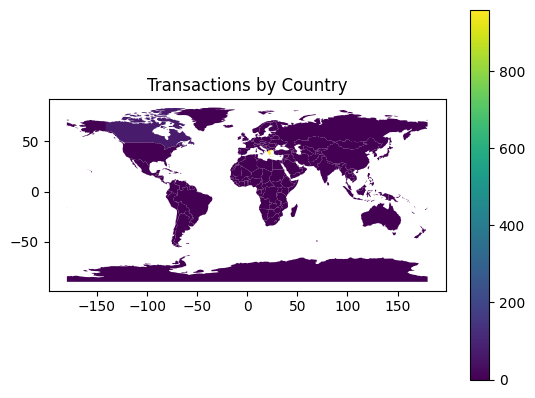

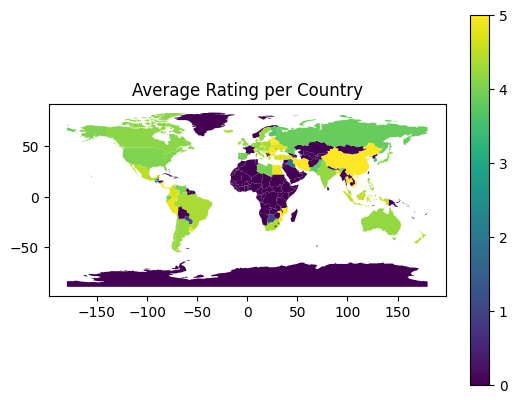

In [105]:
### 4. Geographical development
group_ratings_by_country = stats_ratings_country_dfs.groupby(['Country']).agg(
    daily_avg_per_country = ('Total Average Rating', 'mean')).reset_index()

group_transactions_by_country = sales_df.groupby(['Buyer Country']).agg(
    transaction_count=('Transaction Date', 'count')
).reset_index()

d = {'ISO_A2': group_ratings_by_country['Country'], 'AVG_Rating': group_ratings_by_country['daily_avg_per_country'], 'Transactions':group_transactions_by_country['transaction_count']}
new_frame_ratings_transactions = pd.DataFrame(data=d)
new_frame_ratings_transactions = new_frame_ratings_transactions.fillna(0)

# world map data, so we can merge on the ISO_A2 code of the country
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
gdf = gpd.read_file(url)
# merge and fill the counts for the rest of the countries with 0 
world = gdf.merge(new_frame_ratings_transactions, how="left", left_on="ISO_A2", right_on="ISO_A2").reset_index()
world['Transactions'] = world['Transactions'].fillna(0)
world['AVG_Rating'] = world['AVG_Rating'].fillna(0)

# Plotting
world.plot(column='Transactions', legend=True)
plt.title("Transactions by Country")
world.plot(column='AVG_Rating', legend=True)
plt.title("Average Rating per Country")
plt.show()

In [106]:
### Dashboard creation
output_file('Dashboard.html', title='Dashboard for Emerald-IT')
title = Div(text='<h1 text-align: center>Emerald-IT Dashboard</h1>')
### Sales volume
sales_volume_fig = figure(title = 'Sales Volume',
                          tools=[HoverTool()],
                          tooltips= [("Month", "@x"), ("Transactions Volume", "@top"), ("Amount (EUR)", "@y")],
                          x_range = monthly_sales['Month'].astype(str), 
                          x_axis_label='Month',
                          title_location='above',
                          toolbar_location = None)
sales_volume_fig.title.align = 'center'
sales_volume_fig.vbar(x = monthly_sales['Month'].astype(str), top=monthly_sales['transaction_count'], width=0.8, color=YlGnBu9[0], legend_label='Transactions')
sales_volume_fig.line(x = monthly_sales['Month'].astype(str), y = monthly_sales['total_amount'], color=YlGnBu9[8], line_width=4, legend_label='Amount (EUR)')
sales_volume_fig.legend.location = 'top_left'

### Attribute segmentation
attribute_segmentation_fig1 = figure(title = 'Attribute Segmentation', 
                                     tools=[HoverTool()],
                                     tooltips = [('value', '@y')],
                                     x_range = monthly_sales['Month'].astype(str), 
                                     x_axis_label='Month',
                                     title_location='above',
                                     toolbar_location = None)
attribute_segmentation_fig1.title.align = 'center'
attribute_segmentation_fig2 = figure(title = 'Monthly Transactions by SKU', y_range = monthly_sales['Month'].astype(str), x_axis_label='Transactions',
                                     y_axis_label='Month',
                                     title_location='above',
                                     tools=[HoverTool()],
                                     tooltips = "@Month: @premium",
                                     toolbar_location = None)
attribute_segmentation_fig2.title.align = 'center'
premium_data = sku_sales[sku_sales['Sku Id'] == 'premium']
other_data = sku_sales[sku_sales['Sku Id'] != 'premium']

attribute_segmentation_fig1.line(x=premium_data['Month'].astype(str), y=premium_data['transaction_count'], color=YlGnBu9[1], legend_label='Transaction count - premium')
attribute_segmentation_fig1.line(x=other_data['Month'].astype(str), y=other_data['transaction_count'], color=YlGnBu9[3], legend_label='Transaction count - unlockcharactermanager')
attribute_segmentation_fig1.line(x=premium_data['Month'].astype(str), y=premium_data['total_amount'], color=YlGnBu9[5], legend_label='Amount(EUR) - premium')
attribute_segmentation_fig1.line(x=other_data['Month'].astype(str), y=other_data['total_amount'], color=YlGnBu9[7], legend_label='Amount(EUR) - unlockcharactermanager')
attribute_segmentation_fig1.legend.location = 'top_right'
attribute_segmentation_fig1.legend.click_policy = 'hide'


data = {
    "Month": ["2021-06", "2021-07", "2021-08", "2021-09", "2021-10"],
    "premium": [99, 121, 122, 92, 87],
    "unlockcharactermanager": [131, 166, 142, 142, 134],
}
sku_transaction_counts = pd.DataFrame(data).set_index("Month")
# Reset the index to make 'Month' a column for Bokeh
sku_transaction_counts = sku_transaction_counts.reset_index()

# Extract required elements
categories = sku_transaction_counts["Month"].tolist()  # Months for y-axis
stack_columns = sku_transaction_counts.columns[1:].tolist()  # Stacked bar columns
source = ColumnDataSource(sku_transaction_counts)  
attribute_segmentation_fig2.hbar(y=dodge("Month", -0.2, range=attribute_segmentation_fig2.y_range), right="premium", height=0.4, source=source, color=YlGnBu9[1], legend_label="Premium")
attribute_segmentation_fig2.hbar(y=dodge("Month", 0.2, range=attribute_segmentation_fig2.y_range), right="unlockcharactermanager", height=0.4, source=source, color=YlGnBu9[6], legend_label="Unlock Character Manager")
hover = HoverTool(tooltips=[
    ("Month", "@Month"),
    ("Premium", "@premium"),
    ("Unlock Character Manager", "@unlockcharactermanager")
])
attribute_segmentation_fig2.legend.location = 'top_right'
attribute_segmentation_fig2.add_tools(hover)

### ratings vs stability
group_ratings_by_month['Month'] = group_ratings_by_month['Month'].astype(str)
group_ratings_by_month['angle'] = group_ratings_by_month['daily_avg_per_country'] / group_ratings_by_month['daily_avg_per_country'].sum() * 2 * np.pi
group_ratings_by_month['color'] = YlGnBu9[:7]
average_rating_per_month_fig = figure(title = 'Rating per Month',
                               x_range = (-0.5, 1.0),
                                     tools=[HoverTool()],
                                     tooltips = "@Month: @daily_avg_per_country",
                                     title_location='above',
                                     toolbar_location = None)

crashes_per_month_fig = figure(title = 'Crashes per Month', 
                                     tools=[HoverTool()],
                                     tooltips = "Average rating for @x is @y",
                                     x_range = group_crashes_by_month['Month'].astype(str), 
                                     x_axis_label='Month',
                                      y_range = Range1d(0, group_crashes_by_month['nr_crashes_per_month'].max()+250),
                                      y_axis_label = 'Rating',
                                     title_location='above',
                                     toolbar_location = None)
crashes_per_month_fig.line(x=group_crashes_by_month['Month'].astype(str), y=group_crashes_by_month['nr_crashes_per_month'], color=YlGnBu9[3], legend_label='Crashes')
average_rating_per_month_fig.wedge(x=0, y=1, 
                             radius=0.4, 
                             start_angle=cumsum("angle", include_zero=True), 
                             end_angle=cumsum("angle"), 
                             line_color="white",fill_color="color",
                             legend_field="Month",source = group_ratings_by_month)
average_rating_per_month_fig.title.align='center'
crashes_per_month_fig.title.align='center'
### geographical development
geo_source = GeoJSONDataSource(geojson=world.to_json())
world_fig = figure(title='World Chart Transactions and Average Rating', tooltips=[('Country', '@ISO_A2'), ('Transactions', '@Transactions'), ('Average Rating', '@AVG_Rating')], x_range=(-180, 180), y_range=(-90, 90))
world_fig.title.align = 'center'
world_fig.patches('xs', 'ys', fill_alpha=0.4, 
          line_color='black', line_width=0.5, source=geo_source)

### display
show(column(title, column(row(sales_volume_fig, attribute_segmentation_fig1, attribute_segmentation_fig2), row(crashes_per_month_fig, average_rating_per_month_fig, world_fig))))

In [107]:
###Query to get the countries that rate the app at a 5
group_ratings_by_country[group_ratings_by_country['daily_avg_per_country'] == 5]

,Country,daily_avg_per_country
3,BA,5.0
4,BD,5.0
6,BG,5.0
7,BH,5.0
8,BN,5.0
11,BY,5.0
13,CH,5.0
15,CN,5.0
18,CY,5.0
24,EE,5.0


In [108]:
###Query to see stats crash dataframe --> Chart View
stats_crashes_dfs

,Date,Package Name,Daily Crashes,Daily ANRs,Month
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,15,1,2021-06
1,2021-06-02,com.vansteinengroentjes.apps.ddfive,12,1,2021-06
2,2021-06-03,com.vansteinengroentjes.apps.ddfive,20,1,2021-06
3,2021-06-04,com.vansteinengroentjes.apps.ddfive,13,0,2021-06
4,2021-06-05,com.vansteinengroentjes.apps.ddfive,14,0,2021-06
...,...,...,...,...,...
209,2021-12-27,com.vansteinengroentjes.apps.ddfive,64,0,2021-12
210,2021-12-28,com.vansteinengroentjes.apps.ddfive,60,0,2021-12
211,2021-12-29,com.vansteinengroentjes.apps.ddfive,37,0,2021-12
212,2021-12-30,com.vansteinengroentjes.apps.ddfive,46,1,2021-12


In [109]:
###Query to view index 160 (first big spike in November)
stats_crashes_dfs[:160]

,Date,Package Name,Daily Crashes,Daily ANRs,Month
0,2021-06-01,com.vansteinengroentjes.apps.ddfive,15,1,2021-06
1,2021-06-02,com.vansteinengroentjes.apps.ddfive,12,1,2021-06
2,2021-06-03,com.vansteinengroentjes.apps.ddfive,20,1,2021-06
3,2021-06-04,com.vansteinengroentjes.apps.ddfive,13,0,2021-06
4,2021-06-05,com.vansteinengroentjes.apps.ddfive,14,0,2021-06
...,...,...,...,...,...
155,2021-11-03,com.vansteinengroentjes.apps.ddfive,7,1,2021-11
156,2021-11-04,com.vansteinengroentjes.apps.ddfive,11,0,2021-11
157,2021-11-05,com.vansteinengroentjes.apps.ddfive,10,0,2021-11
158,2021-11-06,com.vansteinengroentjes.apps.ddfive,39,0,2021-11


In [110]:
###Query to find developer replies in November
reviews_dfs[reviews_dfs['Developer Reply Date and Time'].dt.strftime('%Y-%m') == '2021-11']

,Package Name,App Version Code,App Version Name,Reviewer Language,Device,Review Submit Date and Time,Review Submit Millis Since Epoch,Review Last Update Date and Time,Review Last Update Millis Since Epoch,Star Rating,Review Title,Review Text,Developer Reply Date and Time,Developer Reply Millis Since Epoch,Developer Reply Text,Review Link
56,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,sweet,2021-11-09 04:53:13+00:00,1636433593154,2021-11-09T04:53:13Z,1636433593154,3,NaN,I used to really like this app when new conten...,2021-11-09 05:34:14+00:00,1.636436e+12,Thank you for the review. We will add new cont...,http://play.google.com/console/developers/6648...
59,com.vansteinengroentjes.apps.ddfive,282.0,8.0.9,en,H8266,2021-11-17 20:50:13+00:00,1637182213403,2021-11-18T10:30:00Z,1637231400970,3,NaN,"Awkwardly missing wood elves, drow, cleric dom...",2021-11-18 10:52:21+00:00,1.637233e+12,Be sure to checkout our forums at complete-ref...,http://play.google.com/console/developers/6648...
61,com.vansteinengroentjes.apps.ddfive,286.0,8.1.1,en,s5neoltecan,2021-11-21 12:59:42+00:00,1637499582168,2021-11-22T02:18:44Z,1637547524079,3,NaN,I did what you told me to uninstall n re insta...,2021-11-25 07:18:03+00:00,1.637825e+12,We have resolved the issue and you can update ...,http://play.google.com/console/developers/6648...
64,com.vansteinengroentjes.apps.ddfive,NaN,NaN,en,nobleltetmo,2021-11-25 01:52:00+00:00,1637805120589,2021-11-25T01:52:00Z,1637805120589,1,NaN,This app has been down for two weeks now. Such...,2021-11-25 07:17:02+00:00,1.637825e+12,We have resolved the issue. You can update the...,http://play.google.com/console/developers/6648...
65,com.vansteinengroentjes.apps.ddfive,286.0,8.1.1,en,gtesltetmo,2021-11-25 04:32:37+00:00,1637814757722,2021-11-25T09:44:49Z,1637833489332,5,NaN,Absolutely wonderful app! Withnthe recent fix ...,2021-11-25 07:17:39+00:00,1.637825e+12,We have found and resolved the issue and we wi...,http://play.google.com/console/developers/6648...
66,com.vansteinengroentjes.apps.ddfive,288.0,8.1.1,en,mido,2021-11-20 23:49:19+00:00,1637452159254,2021-11-25T15:28:58Z,1637854138748,5,NaN,"The newest update fixed it, re downloaded the ...",2021-11-25 07:18:28+00:00,1.637825e+12,We have resolved the issue and we will release...,http://play.google.com/console/developers/6648...
